Referanslar:

* https://mccormickml.com/2019/07/22/BERT-fine-tuning/ 
* https://www.youtube.com/playlist?list=PLam9sigHPGwOBuH4_4fr-XvDbe5uneaf6
* https://www.youtube.com/playlist?list=PLEJK-H61XlwxpfpVzt3oDLQ8vr1XiEhev
* Bunlara ek olarak NLP ve Pytorch üzerine udemy kursları.

#### İlk olarak Colab ekran kartını kontrol ediyoruz.

In [ ]:
!nvidia-smi

Fri Oct 23 07:35:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Colab üzerinden hızlı transfer için veriyi Drive'a yükledim. Drive üzerinden veriyi çekmek ve oluşturduğumuz modeli Drive'a kaydetmek için Drive'ı Colab'e bağlıyoruz.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Gerekli paketler

In [ ]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

     |████████████████████████████████| 1.3MB 2.8MB/s 
     |████████████████████████████████| 1.1MB 19.2MB/s 
     |████████████████████████████████| 2.9MB 27.7MB/s 
     |████████████████████████████████| 890kB 43.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=c78b41126f3ff0edbcacc1fd89e15b3d385d477a57676b782f1fb809c5f6f8bd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla P100-PCIE-16GB


Veriyi "df" değişkenine atayıp veri hakkında çeşitli bilgilere bakıyoruz.

In [ ]:
df = pd.read_csv("/content/drive/My Drive/sample_complaint_data_90k.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      90000 non-null  object
 1   category  90000 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [ ]:
df.sample(10)

,text,category
84427,Son bir buçuk yıldır işsizim kredimi 1 nisanda...,kredi
29571,Halkbank kredi kartı ve bankamatik kartımı ipt...,iptal
27465,Geçtiğimiz yıllarda üyelik bedeli altında aldı...,iptal
47213,Yaklaşık 3/4 ay kadar önce şahsıma Akbank'dan ...,musteri-hizmetleri
6279,Akbank 6 yıldır müşterisi olmama rağmen Axess ...,kredi-karti
64811,Modacruz firması 16.02.2018 tarihinde saat 09:...,iade
79197,Temel ihtiyaç kredisi başvurusu 2 nisandan ber...,kredi
23474,Akbank tarafından son hanesi 9942 olan Axess k...,iptal
11242,10 yıllık Akbank müşterisiyim kartınızı çok ak...,kredi-karti
21961,2 ay önce Denizbank GS Bonus kredi kartım kayb...,iptal


Hedef değişken eşit bir şekilde dapıtılmış. Bu durum, Bert kendine ait pre-trained tokenizer kullandığı için ve hedef değişken eşit dağıtılmış olduğu için, Veri Manipülasyonu yapmaktan bizi kurtarıyor.

In [ ]:
df.groupby('category').size()

category
hesap                 15000
iade                  15000
iptal                 15000
kredi                 15000
kredi-karti           15000
musteri-hizmetleri    15000
dtype: int64

Kategorik olan hedef değişkeni modelde kullanabilmemiz için kategori kolonunu LabelEncoder metoduyla numerik değerlere atıyoruz.

In [ ]:
df['encoded_categories'] = LabelEncoder().fit_transform(df['category'])

Türkçe Bert tokenizerını indiriyoruz ve "tokenizer" olarak tanımlıyoruz. Yuakrıda bahsettiğim gibi Bert, Vikipedi makaleleri üzerinden eğitilmiş olduğu için kendi tokenizerına sahip. Aslında tokenize etme aşamasına geçmeden önce veri üzerinde temizlik yapılıp yapılmaması gerektiğine bakılmalı. İngilizce dili için Spacy kütüphanesi bu iş için iyi çalışıyor ama Türkçe dili için kaliteli bir NLP kütüphanesi ne yazık ki mevcut değil. Yazım yanlışlarını düzelten bağımsız bir github NLP türkçe kütüphanesi buldum ama kütüphanenin kalitesinden emin olamayacağım için kullanmak istemedim. Bir diğer deyişle kötü bir kütüphaneyle veriyi bozmak istemedim.

Zaten bu süreçte deneme yanılma yoluyla bir çok model denediğim için, elimizde mecut bulunan verinin çok da fazla temizlik ihtiyacı olmadığına, tokenizerın gayet düzgün çalıştığına bu deneme yanılma sürecinde tanık oldum.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)

In [ ]:
sentences = df.text.values

Bert modelinde maksimumtoken sayısı 512 olarak belirlenmiş durumda. Bizim verimizde kelime sayılarının ortalamaları 0-200 kelime arasında. Bert Tokenizer bazı kelimeleri hece olarak ayırdığı için, ortalama token sayısı ortalama kelime sayısından daha çok olacaktır.

Daha önce deneme yanılma yoluyla oluşturduğum bir Distilbert modelinde maksimum token sayısını (max_len değişkenini) 512 olarak belirlemiştim ve elde ettiğim model performansı 280'e kıyasla neredeyse hiç fark etmemişti. 100 ve 200 değerlerini denediğimde ise %10'a kadar azalma olduğunu gözlemledim. Kelime sayılarında, Outllier'ı görmezden gelerek baktığımızda 0-200 arasında bir normal dağılım gözlemleniyor, buna Bert Tokenizer'ın kendine özgü tokenize etme yöntemiyle oluşturduğu heceleri de dahil edince 280 değerinin iyi olacağını düşündüm, ve modeli eğittimde, gerçekten de 512 değerinden çok farklı olmadığını gözlemledim.

Ek olarak model eğitme hızını hızlandırmak için minimum batch size değerini 32 yapmak istiyordum ve [bu linkte](https://www.youtube.com/watch?v=VRNYw_elzP4) anlatılanlardan yola çıkarak, Colab'de verilen ekran kartlarında(Tesla K80, P100 ve T4 kartları için. P4 6GB RAM'e sahip olduğu için bu duruma dahil değil) min batch size 32 için, maks sequence length'in 280 olabileceğini gözlemledim.

In [ ]:
max_len = 280

burada elimizdeki metin verisini %80 ve %20 oranıyla, sırasıyla training ve test olarak ikiye bölüyoruz

In [ ]:
training = df.groupby('category').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)

In [ ]:
print("Training: ", len(training))
print("Test: ", len(test))

Training:  72000
Test:  18000


In [ ]:
training_texts = training.text.values
training_labels = training.encoded_categories.values

bu kısımda metin verisini modelde kullanmak üzere işliyoruz. öncelikle cümledeki kelimeler indirdiğimiz tokenizer ile tokenize ediliyor, sonrasında sınıflandırma probleminin çözülebilmesi için gerekli olan token'lar cümlenin sonuna ve başına ekleniyor. cümle maksimum uzunluktan kısaysa, input vektörümüz sabit uzunlukta olduğu için boşluklar dolduruluyor, uzunsa metin limit kadar kelime ile ifade ediliyor. attention mask'leri oluşturuluyor ve metinler işlemin sonucunda tensor objesi olarak geri dönüyor.

aşağıdaki çıktıda da görüldüğü üzere, metindeki kelimeler tokenizer'daki kelimelerin id'leri ile ifade ediliyor ve bu şekilde işleme sokuluyor.

Bu kısımda modele sunmak üzre input_id ve attention_mask değişkenlerini oluşturuyoruz. Bu işlem için kısaca sınırladığımız maksimum sequence length uyarınca (max_len=280) metinler tokenize ediliyor. Eğer bir satır tokenize edildikten sonra 280'den daha az değere sahipse, eksik olduğu kadar pad ekleniyor (yani 120 uzunluğundaysa 160 adet pad ekleniyor), 280'den fazlaysa 280 değerine kadar kısaltılıyor ve o kısaltılmış haliyle kullanılıyor. Pad'ler basit bir şekilde anlam barındırmayan ekstra 0 değerlerinden oluşuyor. Tokenize edildikten sonra, oluşturulmuş tokenlerin anlamlı oluğ olmadığını modele belirtmek üzere attention mask oluşturuluyor. Örnek olarak bir metin 100 token haline gelmişse ve maksimum sequence length'e ulaşması için sonuna 180 tane pad eklenmişse, sadece bu ilk 100 tokenin anlam barındırdığını, son 180 tokenin anlam barındırmadığını ifade eden bir attention mask üretiliyor. Bu Attention Mask'in formatından emin değilim ancak binary olduğunu düşünüyorum, az önceki örnekteki metin için oluşturulan attention mask için ilk 100 değerde 1'ler, sonraki 180 değerde ise 0'lar barınıdırıyor olabilir. Son olarak, oluşturudğumuz bu değerleri modelde kullanabilmek için tensor haline getiriyoruz. Tokenizasyon'dan sonraki hali, orjinal metin ile kıyaslanarak hücre çıktısında görülebilir.

Not: Aslında bu noktada padding uygulamadan token miktarı dağılıma grafik olarak bakmak isterdim ama bu notebook'u cuma günü oluşturduğum için ve notebook'un yorum kısımlarını yazmayı son gün, son saate bıraktığım için bütün hücreleri tekrardan çalıştırmaya vaktim yok. Başka bir zaman daha detaylı bir Bert Tokenization araştırması yapılabilir.

In [ ]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Banka hesabından 3 adet otomatik çekilen ücret bulunmaktadır. Bu konu hakkında telefon bankacılığını aradım ama yardımcı olamadılar. Telefon bankacılığı ise benim internette gördüğüm bilgileri görebiliyor ekstra bilgi veremediler ve tatmin olmadım. Telefona gelen 2 adet SMS'te ayın 17 sinde 2 adet sigortam olduğunu ve otomatik para çekileceği yazıyordu. 
Bu ayın 3' ünde 3 ayrı kalemde farklı fiyattan hesabımdan para çekilmiş. Bu konu hakkında bilgi almam lazım. Telefonla Beylikdüzü şubemle görüşmeye çalıştım. 2 saat boyunca kimseye ulaşamadım. 
Hesaplarımın incelenerek bana yardımcı olunmasını istiyorum. Poliçeleri kontrol ettiğimde 2 adet poliçenin çekildiği gözüküyor.
Token IDs: tensor([     2,   3730,  14845,     23,   3764,   5774,  93844,   2074,  45298,
          4698,     18,   1964,   2580,   2826,   3035,  32521,  49313,  18847,
         17300,   2156,   3679,  94826,     18,   3035,  32521,  49313,   2319,
          2633,  13201, 118840,   5130,  22586,   6356,  10

Tensor veri seti haline getiriyoruz.

In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

Oluşturduğumuz tensor verisini modele vermek üzere *dataloader* değişkenine dönüştürüyoruz.

Yukarıda da belirtiğim üzere 280 sequence length için seçilebilecek maksimum batch size değeri 32 olduğundan bu değeri bu şekilde seçiyorum.

In [ ]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

model'de kullanmak üzere hedef değişkenin kaç farklı değişkenden oluştuğunu belirliyoruz

In [ ]:
number_of_categories = len(df['encoded_categories'].unique())

Pre-Trained Bert Base Türkçe modelini indiriyoruz.

Bı kısımda, OOP konusunda çok tecrübesiz olduğum için, modeli sıfırdan oluşturduğumuz bir class üzerinden tanımlamak yerine transformers kütüphanesi içinde hazır bulunan BertForSequenceClassification class'ını kullanıyorum. Bu class içerisinde Classification için ihtiyacımız olan bütün fonksiyonlar tanımlı bulunuyor.

En altta *model.cuda()* metotu ile modelin GPU'da kullanılacağını belirtiyoruz.

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

### Hiperparametreler

Training'e başlamadan önce, toplam epoch sayısını ve kullancağımız optimizer'ı belirliyoruz. AdamW kullanmamın  belirli bir sebebi yok, sequence classification için herkesin Adam kullandığını gördüğüm için ben de onu seçtim.

Başlangıç (initial) Learning rate değerini 0.0001 olarak seçmenin sebebi ise yine deneme yanılma yöntemiyle daha önceden oluşturduğum modeller sonucuyla vardığım bir değer. 0.0001 değeri hem standart 2e-5 değerine kıyasla daha hızlı eğitmeye olanak tanıyor, hem de 2e-5 değerine kıyasla accuracy üzerinde ciddi farklar yaratmıyor. 

Ek olarak, Ktrain kütüphanesinde optimum learning rate değerini simüle eden bir fonksiyon var. Bu fonksiyon ile vardığım değer de yine 0.001 idi.

Epsilon değeri (eps = 1e-8) model weightlerini update etmek için kullanılıyor. Bu değerle ilgili çok fazla bilgim olmadığı için default olarak seçtim ve hiç oynamadım.

Scheduler ise, seçtimiz parametreler hiperparametre oldukları için, bu değerlerin train süresince değişimini belirli standartlara göre kontrol eden bir fonksiyon. Yine çok detaylı bilgiye sahip olmadığım için ancak bu kadar açıklayabiliyorum. Hugging Face sitesindeki tanım şu şekilde:

*Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.*

In [ ]:
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 0.0001,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

Referans aldığım notebook'taki seed değeriyle aynı seed değerini seçtim. 42 değeri biraz da manidar olduğu için dokunmak istemedim.

Modeli 4 epoch boyunca eğitiyoruz. Dataloader'a aktardığımız verisetini, her defasında 32 tane olacak şekilde training boyunca modele veriyoruz. Her bölüm başlamadan önce optimize edilecek loss değeri sıfırlanıyor. Daha sonra test sürecinde eval() metodunun kullanılabilmesi için Modelin train() metodu çağırılıyor çünkü modelin katmanları train ve eval metodlarında farklı olarak davranıyor. dataloader'daki değerler GPU'ya aktarılıyor, gradient değerleri sıfırlanıyor ve output (logit) değerleri oluşuyor ve buna bağlı olarak loss değeri hesaplanıyor. backpropogation ile gradient'ler tekrar hesaplanıyor ve son olarak da learnig rate'le beraber parametreler de optimize ediliyor. her epoch sonunda ortalama loss print ediliyor.

In [ ]:
# Bu training kodu aşağıdaki linktedi `run_glue.py` script'i baz alınarak oluşturulmuştur:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 4 ========
Batch    50  of  2,250.    Elapsed: 0:00:44.
Batch   100  of  2,250.    Elapsed: 0:01:27.
Batch   150  of  2,250.    Elapsed: 0:02:11.
Batch   200  of  2,250.    Elapsed: 0:02:54.
Batch   250  of  2,250.    Elapsed: 0:03:38.
Batch   300  of  2,250.    Elapsed: 0:04:21.
Batch   350  of  2,250.    Elapsed: 0:05:05.
Batch   400  of  2,250.    Elapsed: 0:05:48.
Batch   450  of  2,250.    Elapsed: 0:06:32.
Batch   500  of  2,250.    Elapsed: 0:07:15.
Batch   550  of  2,250.    Elapsed: 0:07:59.
Batch   600  of  2,250.    Elapsed: 0:08:42.
Batch   650  of  2,250.    Elapsed: 0:09:26.
Batch   700  of  2,250.    Elapsed: 0:10:09.
Batch   750  of  2,250.    Elapsed: 0:10:53.
Batch   800  of  2,250.    Elapsed: 0:11:36.
Batch   850  of  2,250.    Elapsed: 0:12:20.
Batch   900  of  2,250.    Elapsed: 0:13:03.
Batch   950  of  2,250.    Elapsed: 0:13:47.
Batch 1,000  of  2,250.    Elapsed: 0:14:30.
Batch 1,050  of  2,250.    Elapsed: 0:15:14.
Batch 1,100  of  2,250.  

training'deki model performansı incelemek için loss'daki düşüşü inceliyoruz.

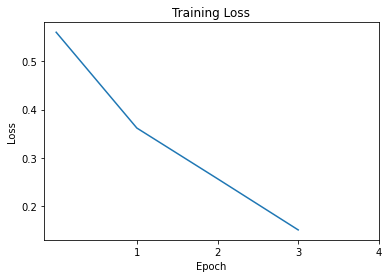

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

training verisetinde olduğu gibi, test veriseti için de bir dataloader oluşturuyoruz.

In [ ]:
test_texts = test.text.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


test verisini kullanarak modele sonuçları tahmin ettiriyoruz. batch değerimiz 32 olduğu için, model training'de olduğu gibi prediction kısmında da 32'şer 32'şer input'ları modele veriyor. o yüzden flatten fonksiyonu ile bütün sonuçları tek bir listede topluyoruz ve prediction_set değişkeninde saklıyoruz.

In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

Prediction started on test data
Prediction completed


In [ ]:
prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Bu kısımda Precision, Recall ve F-score değerlerini çıkartıyoruz, modelin performansını gözlemliyoruz.

In [ ]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

Sequence length'i 280'e kısıtlamış olsak da gayet iyi bir F-Score ve Precision elde edebildik.

In [ ]:
print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

F-Score:  0.878444187384857
Recall:  0.8784999999999998
Precision:  0.8785004569575245


In [ ]:
report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))

In [ ]:
report = report.rename(columns={'0':'hesap',
                          '1':'iade',
                          '2':'iptal',
                          '3':'kredi',
                          '4':'kredi-karti',
                          '5':'musteri-hizmetleri'})

In [ ]:
report

,hesap,iade,iptal,kredi,kredi-karti,musteri-hizmetleri,accuracy,macro avg,weighted avg
precision,0.875342,0.854449,0.907377,0.902225,0.840225,0.891385,0.8785,0.878500,0.878500
recall,0.854333,0.861000,0.930667,0.892000,0.846667,0.886333,0.8785,0.878500,0.878500
f1-score,0.864710,0.857712,0.918874,0.897083,0.843434,0.888852,0.8785,0.878444,0.878444
support,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,0.8785,18000.000000,18000.000000


Son olarak, api'de kullanmak üzere modeli ve tokenizer'ı Drive'a kaydediyoruz. Bunun için transformers'ın save_pretrained methodunu kullanıyoruz.

In [ ]:
tokenizer.save_pretrained('/content/drive/My Drive/bert_token_save')
model.save_pretrained('/content/drive/My Drive/bert_model_save')

# API

Bu notebook'da oluşturulan model için kurulan api'yi, github repo'sunda Bert_app adlı klasörün içinde bulabilirsiniz.
Api'yi FastAPI kullanarak oluşturdum.